In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import clusterbycolumn as cbc
import requests
import asinfo

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , successes
                  , failures
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and error_code <> 607
           and msmpoint.skunitid <> ''
           order by dtime DESC
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.head()

,probe,dtime,video_address,successes,failures
0,samsbox08,2017-06-27 23:37:44,2001:b30:ef00:99ca::c,1,0
1,samsbox08,2017-06-27 23:36:40,195.95.178.204,1,0
2,samsbox45,2017-06-27 23:36:12,None,0,1
3,samsbox03,2017-06-27 23:36:00,2001:1a80:801::c,1,0
4,samsbox45,2017-06-27 23:35:09,173.194.20.202,1,0


In [9]:
num_probes = len(set(df['probe']))

In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,successes,failures
0,samsbox08,2017-06-27 23:00:00,2001:b30:ef00:99ca::c,1,0
1,samsbox08,2017-06-27 23:00:00,195.95.178.204,1,0
2,samsbox45,2017-06-27 23:00:00,None,0,1
3,samsbox03,2017-06-27 23:00:00,2001:1a80:801::c,1,0
4,samsbox45,2017-06-27 23:00:00,173.194.20.202,1,0


In [13]:
df.tail()

,probe,dtime,video_address,successes,failures
4886447,samsbox03,2014-12-10 12:00:00,2001:1a80:100:1b::e,1,0
4886448,samsbox02,2014-12-10 12:00:00,2a00:1450:4005:6::12,1,0
4886449,samsbox02,2014-12-10 12:00:00,64.15.112.79,1,0
4886450,samsbox06,2014-12-10 12:00:00,2a00:1450:4002:9::12,1,0
4886451,samsbox06,2014-12-10 12:00:00,149.3.177.111,1,0


In [14]:
df.count()

probe            4886452
dtime            4886452
video_address    4378415
successes        4886452
failures         4886452
dtype: int64

In [15]:
def get_af_from_endpoint(ep):
    if ep is None: return None
    elif fbi.if_ipv6(ep): return 'v6'
    elif fbi.if_ipv4(ep): return 'v4'
    else: print('.'); return None

In [16]:
df['af'] = df['video_address'].apply(get_af_from_endpoint)

.


In [17]:
df.count()

probe            4886452
dtime            4886452
video_address    4378415
successes        4886452
failures         4886452
af               4378414
dtype: int64

In [18]:
df.head()

,probe,dtime,video_address,successes,failures,af
0,samsbox08,2017-06-27 23:00:00,2001:b30:ef00:99ca::c,1,0,v6
1,samsbox08,2017-06-27 23:00:00,195.95.178.204,1,0,v4
2,samsbox45,2017-06-27 23:00:00,None,0,1,None
3,samsbox03,2017-06-27 23:00:00,2001:1a80:801::c,1,0,v6
4,samsbox45,2017-06-27 23:00:00,173.194.20.202,1,0,v4


In [19]:
dfgroupby = cbc.group(df, column=['probe', 'af'])

In [20]:
df_agg = cbc.aggregate(dfgroupby, ['successes', 'failures'], ['sum', 'count'])

In [21]:
df_merged = cbc.merge(df, df_agg, column=['probe', 'af'])

In [22]:
df = df_merged.drop(['dtime', 'video_address', 'successes', 'failures'], axis=1)

In [23]:
df = df.drop_duplicates()

In [24]:
df.rename( columns={  df.columns[-1]: 'failures_count'
                    , df.columns[-2]: 'failures_sum'
                    , df.columns[-3]: 'successes_count'
                    , df.columns[-4]: 'successes_sum'}
                , inplace=True)

In [25]:
dfv6 = df[df.af == 'v6']
dfv4 = df[df.af == 'v4']

In [26]:
dfv6.head()

,probe,af,successes_sum,successes_count,failures_sum,failures_count
0,samsbox08,v6,24245,24554,309,24554
3,samsbox03,v6,35640,35730,90,35730
6,samsbox97,v6,14350,14353,3,14353
8,samsbox51,v6,27986,28323,337,28323
9,samsbox33,v6,28717,29152,435,29152


In [27]:
def cal_success_rate(x):
    success = x['successes_sum']
    total   = x['successes_count']    
    
    rate = (success / total) * 100
    return rate

dfv6['success_rate'] = dfv6.apply(cal_success_rate, axis = 1)
dfv4['success_rate'] = dfv4.apply(cal_success_rate, axis = 1)

In [28]:
dfv4.head()

,probe,af,successes_sum,successes_count,failures_sum,failures_count,success_rate
1,samsbox08,v4,29529,29844,315,29844,98.944511
4,samsbox45,v4,33295,33604,309,33604,99.080467
5,samsbox03,v4,34424,34454,30,34454,99.912927
7,samsbox97,v4,15413,15413,0,15413,100.000000
12,samsbox51,v4,28422,28831,409,28831,98.581388


In [29]:
import Cdf
import Pmf
samplev4 = dfv4['success_rate'].values
samplev6 = dfv6['success_rate'].values

c4 = Cdf.MakeCdfFromList(samplev4)
c6 = Cdf.MakeCdfFromList(samplev6)

cc4 = [1 - p for x, p in c4.Items()]
cc6 = [1 - p for x, p in c6.Items()]

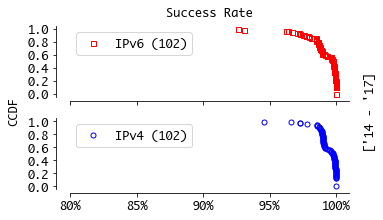

In [55]:
fig = plt.figure(figsize=(5, 3))
plt.rcParams['font.size'] = 12

yticks = np.arange(0,1.1,0.2)
xticks = np.arange(80,110,10)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

ax1.plot(c6.xs, cc6, marker='s', linewidth=0, markersize=5, fillstyle='none', color = 'Red')
ax2.plot(c4.xs, cc4, marker='o', linewidth=0, markersize=5, fillstyle='none', color = 'Blue')

ax1.set_xlim([80,101])
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.set_xscale('linear')
ax1.set_xlabel('', fontsize=12)

ax1.grid(False)
ax1.legend(['IPv6 (102)'], fontsize=12, loc='best')

ax2.set_xlim([80,101])
ax2.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.set_xscale('linear')
ax2.set_xlabel('', fontsize=12)

ax2.grid(False)
ax2.legend(['IPv4 (102)'], fontsize=12, loc='best')

ax1_ = ax1.twinx()
ax1_.spines['right'].set_color('none')
ax1_.spines['top'].set_color('none')
ax1_.spines['left'].set_color('none')
ax1_.spines['bottom'].set_color('none')
ax1_.yaxis.set_ticks_position('none')
ax1_.set_ylabel('[\'14 - \'17]', fontsize = 12)
ax1_.yaxis.set_label_coords(1.05, -0.2)
plt.setp(ax1_.get_yticklabels(), visible=False)

fig.subplots_adjust(hspace = 0.3)

def to_percent(x, position): return str(int(x)) + '%'
ax1.xaxis.set_major_formatter(FuncFormatter(to_percent))
ax2.xaxis.set_major_formatter(FuncFormatter(to_percent))

plt.setp(ax1.get_xticklabels(), visible=False)

ax1.yaxis.set_label_coords(-0.18, -0.2)
ax1.set_ylabel('CCDF', fontsize=12)

ax1.set_title('Success Rate', fontsize=12, y=1.05)
plt.savefig('yt-success-rate-ccdf.pdf', format='pdf', bbox_inches='tight')

In [33]:
with open('yt-success-rate-v4.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c4.xs, cc4): f.write('%.2f; %.2f\n'%(x,y))
        
with open('yt-success-rate-v6.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c6.xs, cc6): f.write('%.2f; %.2f\n'%(x,y))        